**Network Architecture** <br><br>
For sentence / text embeddings, we want to map a variable length input text to a fixed sized dense vector. The most basic network architecture we can use is the following:

1. We use a pretrained language model (e.g. BERT, RoBERTa, DistilBERT, ALBERT, XLNet, XLM-RoBERTa, CamemBERT, ELECTRA, Longformer, Reformer, BigBird, T5, GPT-2, CTRL, ...) to get contextual word embeddings for each token in the input text.
2. We apply a pooling operation to get one vector representation for the whole input sequence
3. We use a feed-forward network to map the pooled sequence vector to the desired output dimension



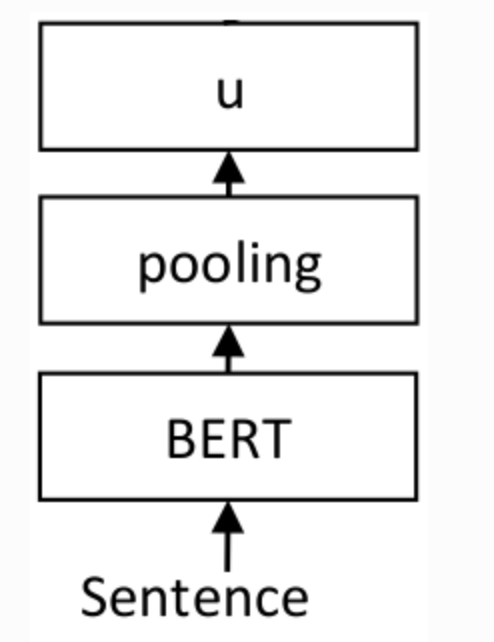


------

In [1]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model_1 = SentenceTransformer(modules=[word_embedding_model, pooling_model])
print(model_1)
print(model_1.get_sentence_embedding_dimension())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)
768


In [2]:
# Model 2
# Here we add a dense layer to the model. The layer will have 256 neurons and use Tanh as the activation function, We use Tanh as the activation function because it is the default activation function used in BERT
# The dense layer.....

dense_model = models.Dense(in_features = pooling_model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())
model_2 = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

print(model_2)
print(model_2.get_sentence_embedding_dimension())

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 384, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)
384


In [3]:
# Model 3

model_3 = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

print(model_3)
print(model_3.get_sentence_embedding_dimension())

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)
384


### Evaluation

In [4]:
import datasets
sts = datasets.load_dataset('glue', 'stsb', split='validation')
sts

Found cached dataset glue (/Users/olang/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 1500
})

In [5]:
# Because the similarity scores range from 0 -> 5, we need to normalize them to a range of 0 -> 1
sts = sts.map(lambda x: {'label': x['label'] / 5.0})

Loading cached processed dataset at /Users/olang/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-18d2b6495b7b8793.arrow


In [6]:
from sentence_transformers import InputExample
from tqdm import tqdm

samples = []
for sample in tqdm(sts):
    samples.append(InputExample(
        texts=[sample['sentence1'], sample['sentence2']],
        label=sample['label']
    ))

100%|██████████| 1500/1500 [00:00<00:00, 13313.11it/s]


In [7]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    samples, write_csv=False
)

In [8]:
evaluator(model_1)

0.6146254070526513

In [9]:
evaluator(model_2)

0.6047098130388097

In [10]:
evaluator(model_3)

0.8671631190200253

### STS Benchmark Results && Discussion

- The first model (BERT with added Pooling layer) is the most basic model. It is a good starting point and achieves a correlation of 0.615 on the STS benchmark.
- The second model (BERT with added Pooling layer and a dense layer) is a bit more complex. It achieves a correlation of 0.611 on the STS benchmark.
- The third model (all-MiniLM-L6-v2) is the most complex model. It achieves a correlation of 0.867 on the STS benchmark. It is also the best model in terms of correlation on the STS benchmark.

<br><br>
Clearly the more complex models perform better. However, the difference between the first and the third model is not that big. The first model is a good starting point and can be used for many applications. The third model is more complex and achieves better results, but it is also more expensive to train and requires more memory. So it is not always necessary to use the most complex model.

### Conclusion
For now the next step is to try and improve the correlation of the first model. We will do this by using a more complex pooling operation. We will also try to use a more complex feed-forward network. If all goes well we can then transfer and test this concept on a low resource language to see if performance  will hold or improve.
